## Problem set #2


### Q1
##### Which of the linear models below are multiple linear regressions?

(1) µi = α + βxi

(2) µi = β1 * xi + β2 * zi

(3) µi = α + β(xi − zi)

(4) µi = α + β1 * xi + β2 * zi

Answer: 2 and 4

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import pandas as pd
import pymc3 as pm
from quap import quap
import arviz as az
import statsmodels.api as sm
import math

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Q2
**I am trying to model the effect of education on fame - in other words I want to know whether having more years of education improves a person's chances of being famous.**

**Give 1 example of a variable I might want to control for in my model. What could happen if I don't control for it?**

1 example: having rich/famous parents. If you don't control for parents it may look like there is a positive effect of education on fame, when in fact both are caused by the parents.

### Q3
**Write the model definition for the above model. Should you center any variables? Justify your priors.**


Fame_i ~ Normal(µi,σi)
µi = α + β1 * Educ_i + β2 * Parents_fame_i

α ~ Lognormal(0,10)   Fame can't be negative.
β1 ~ Normal(0,10)  This is a skeptical prior centered on 0 so as to not presuppose either a positive or negative effect
β2 ~ Normal (0,10) See prior for β1
σ ~ Exp(1) Common prior for standard deviations

I am not centering eiher variable, because there should in principle be data of people with no education and no parental fame, so the intercept can be interpreted as the probability of fame for those individuals.


### Q4
I want to set up an experiment looking at the effect of social media use on anxiety and test scores. Help me simulate this.

First simulate baseline anxiety levels for a group of 100 students. Anxiety is scored between 0 and 10 and the average score is 5 with a standard deviation of 2. Remember that you can't score lower than 0 or higher than 10!

Next assign half of them at random to the experimental group which is given access to social media. 

Simulate student's scores after the treatment. On average, the control group (with no access to social media) have the same score, while the experimental group increased their anxiety by 1 point on average.

Simulate student's test scores out of 100. The average score for a student without anxiety is 80% with a standard deviation of of 15 points, but each point of anxiety decreases a student's score by 2 points on average. (again, remember that scores cannot be more than 100 or less than 0).

Create a data frame with experimental status, post-experiment anxiety, and test scores and show the first 6 rows.

In [3]:
# number of students
N = 100
# simulate initial anxiety
a0 = np.random.normal(5, 2, N)
a0[a0>10] = 10
a0[a0<0] = 0
# assign treatments 
soc_med = np.repeat([0, 1], N / 2)

# simulate anxiety post treatment
a1 = np.random.normal(a0 + soc_med, 1)
a1[a1>10] = 10
a1[a1<0] = 0

# simulate test scores
s = np.random.normal(80 - a1*2, 15)
s[s>100] = 100
s[s<0] = 0
# compose a clean data frame
d = pd.DataFrame.from_dict({"a1": a1, "SocialMedia": soc_med, "TestScore": s})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a1,5.37,2.21,1.73,9.52
SocialMedia,0.50,0.50,0.00,1.00
TestScore,70.99,13.84,51.18,100.00


### Q5
Your colleague tells you to put model test scores using a multiple linear regression with anxiety and experimental status as predictor variables. Why is this a bad idea?

To appease them, you do it anyway. Present the results in a forest plot. Interpret the meaning of each of the parameter estimates. What model should you run instead? Present these results in another forest plot and interpret the results for your colleague.

In [5]:
with pm.Model() as m_tests:
    a = pm.Uniform("a", 0, 100)
    b1 = pm.Normal("b1", 0, 2)
    b2 = pm.Normal("b2", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    
    mu = a + b1 * d.SocialMedia + b2 * d.a1

    TestScore = pm.Normal(
        "TestScore", mu=mu, sigma=sigma, observed=d.TestScore
    )
    prior_samples = pm.sample_prior_predictive()
    idata,dist = quap(vars=[a,b1,b2,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [7]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,82.267,2.846,77.778,86.880
b1,-0.532,1.563,-2.949,2.043
b2,-2.053,0.485,-2.855,-1.292
sigma,11.809,0.782,10.572,13.055


a is the intercept. It can be interpreted to mean that the average score for someone with no anxiety or access to social media is predicted to be 82.267.

b1 can be interpreted to mean that on average, someone with access to social media, given a fixed level of anxiety, will have a score 0.5 points lower that someone without (but with a hdi that straddles 0, so no clear effet).

b2 can be interpreted to mean that on average, for every extra point of anxiety students can be expected to lose 2.05 points on their test.

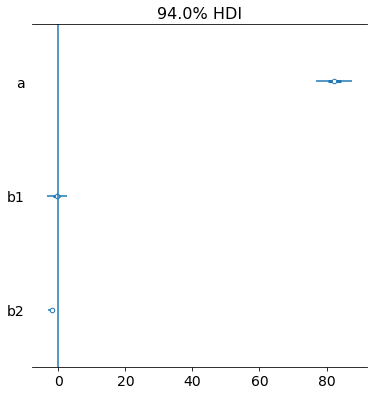

In [6]:
az.plot_forest(
    idata,
    var_names=["a","b1", "b2"],
)
plt.axvline(0)

### Q6
Load the data /Data/drinking_fatalities.csv. This is a dataset of US states between 1982 and 1988, with data on the minimum legal drinking age. Your colleague from the previous question tells you they have found an interesting result. They find that states with more average miles driven per person have higher minimum legal drinking ages. They interpret this to mean that states adjust their legal drinking ages upwards when people drive a lot.

Run a simple linear model with "mlda" as the outcome and "avgmiles" as the predictor. Present the parameter estimates and their 89% hdis and interpret each of them. Plot the predicted relationship between avgmiles and mlda along with the 89% hdi for the mean and the 89% hdi for the predictions.

Do you come to the same conclusion as your colleague?

In [5]:
d = pd.read_csv("./../data/drinking_fatalities.csv", delimiter=",")

with pm.Model() as drink:
    a = pm.Normal("a", mu=20, sd=3)
    b = pm.Normal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = a + b * (d.avgmiles-min(d.avgmiles))
    mlda = pm.Normal("mlda", mu=mu, sd=sigma, observed=d.mlda)
    idata,dist = quap(vars=[a,b,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)



In [15]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,20.337,0.121,20.139,20.523
b,0.036,0.033,-0.016,0.090
sigma,0.897,0.034,0.843,0.952


Because we've centered the predictor variable on the minimum, we can interpret a to mean that  the predicted minimum legal age to drink in a the state with the lowest numbers of miles driven is 20.3, with a 89% probability that its between 20.13 and 20.523.
b=0.036 means that for every additional average mile driven, the minimum legal age to drink is predicted to increase by 0.036 years (or approximately 13 days), with an 89% probability that its between -0.016 and 0.09


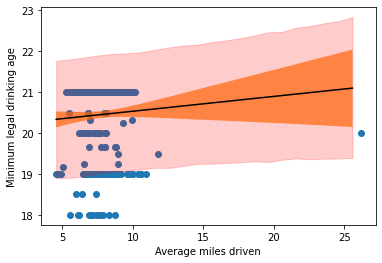

In [14]:
avgmiles_seq = np.arange(d.avgmiles.min(), d.avgmiles.max())
mu_pred = np.zeros((len(weight_seq), len(samples)))
height_pred = np.zeros((len(weight_seq), len(samples)))
for i, w in enumerate(weight_seq):
    mu_pred[i] = samples["a"] + samples["b"] * (w - d.avgmiles.min())
    height_pred[i] = np.random.normal(mu_pred[i], samples["sigma"])

plt.scatter(d.avgmiles, d.mlda)
plt.plot(weight_seq, mu_pred.mean(1), "k")
plt.fill_between(weight_seq, np.quantile(mu_pred,0.055,axis=1), np.quantile(mu_pred,0.945,axis=1), alpha=0.7)
plt.fill_between(weight_seq, np.quantile(height_pred,0.055,axis=1), np.quantile(height_pred,0.945,axis=1), alpha=0.2,color='red')
plt.xlabel("Average miles driven")
plt.ylabel("Minimum legal drinking age")
plt.show()


I do not come to the same conclusion as my colleague. Although the average predicted slope is indeed positive, there is a lot of uncertainty,and 0 is included in the 89% hdi for the slope. Thus, we cannot conclude that there is a strong positive relationship between miles driven and mlda.

### Q7
You ask your colleague how they specified their model. They tell you they controlled for the traffic fatality rate, trafficmort. Rerun the previous model adding trafficmort as a control. Once again, present the parameter estimates and interpret them, and plot the predicted relationship between avgmiles and mlda along with the 89% hdi for the mean and the 89% hdi for the predictions. What is different in this model?

Think about the causal relationship between traffic fatality rates, average driving rates, and legal drinking age. Do you think your colleague's model specification was appropriate? Why or why not? What do you conclude about the true relationship between driving rates and the drinking age?

In [6]:
with pm.Model() as drink_collider:
    a = pm.Normal("a", mu=20, sd=3)
    b1 = pm.Normal("b1", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = a + b1 * (d.avgmiles-min(d.avgmiles)) + b2*d.trafficmort
    mlda = pm.Normal("mlda", mu=mu, sd=sigma, observed=d.mlda)
    idata,dist = quap(vars=[a,b1,b2,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)


In [7]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,20.662,0.187,20.359,20.956
b1,0.069,0.036,0.015,0.128
b2,-0.212,0.092,-0.364,-0.069
sigma,0.889,0.034,0.834,0.943


In this model the parameter estimate b1 is now significantly positive, with an 89% hdi that doesn't cover 0. However, the decision to control for mortality rates is incorrect. Mortality is a collider here. High mortality can occur if mlda is low OR if people drive a lot, so controlling for mortality creates a spurious association between mortality and driving.